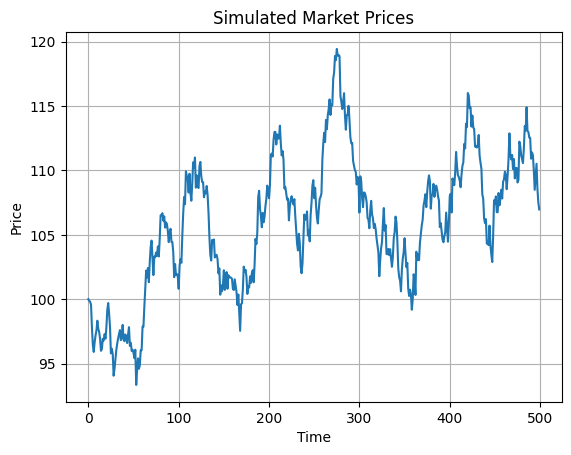

In [1]:
import numpy as np
import matplotlib.pyplot as plt

class Trader:
    def __init__(self, strategy="random", size=1.0):
        self.strategy = strategy
        self.size = size
        self.last_price = None

    def act(self, mid_price, order_book, order_jitter=0.01):
        if self.strategy == "random":
            price = mid_price * (1 + order_jitter * np.random.randn())
            return price, "random"

        elif self.strategy == "trend":
            if self.last_price is None:
                self.last_price = mid_price
                return mid_price, "trend"
            delta = mid_price - self.last_price
            self.last_price = mid_price
            if delta > 0:
                price = mid_price * 1.01
            else:
                price = mid_price * 0.99
            return price, "trend"

        elif self.strategy == "hft":
            if np.random.rand() > 0.5:
                price = mid_price * 0.998
            else:
                price = mid_price * 1.002
            return price, "hft"

        elif self.strategy == "whale":
            price = mid_price * (1 + order_jitter * np.random.randn())
            return price, "whale"

def simulate_market(steps=500, n_traders=300, whale_ratio=0.05, trend_ratio=0.2, hft_ratio=0.2):
    order_book = []
    prices = []
    traders = []

    for _ in range(n_traders):
        r = np.random.rand()
        if r < whale_ratio:
            traders.append(Trader(strategy="whale", size=20.0))
        elif r < whale_ratio + trend_ratio:
            traders.append(Trader(strategy="trend"))
        elif r < whale_ratio + trend_ratio + hft_ratio:
            traders.append(Trader(strategy="hft"))
        else:
            traders.append(Trader(strategy="random"))

    order_book.append(100.0)

    for step in range(steps):
        mid_price = np.mean(order_book[-min(len(order_book), 50):])
        prices.append(mid_price)

        for trader in traders:
            price, strategy = trader.act(mid_price, order_book)
            if len(order_book) > 0:
                closest = min(order_book, key=lambda x: abs(x - price))
                order_book.remove(closest)
            order_book.append(price)

    return prices

def plot_prices(prices):
    plt.plot(prices)
    plt.title("Simulated Market Prices")
    plt.xlabel("Time")
    plt.ylabel("Price")
    plt.grid(True)
    plt.show()

prices = simulate_market()
plot_prices(prices)

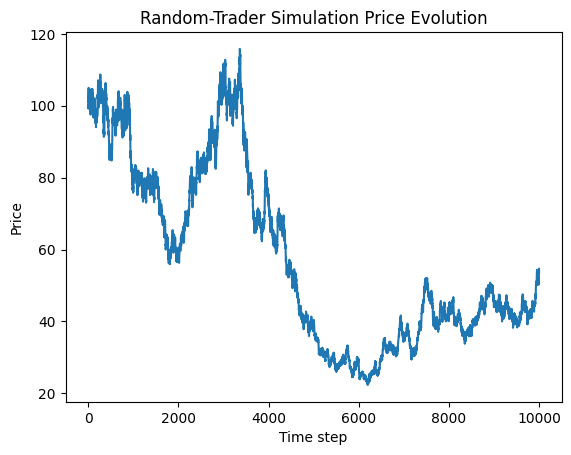

In [27]:
import numpy as np
import matplotlib.pyplot as plt

class Order:
    def __init__(self, price, size=1):
        self.price, self.size = price, size

def run_sim(n_steps=10000, init_price=100.0, n_ticks=1000, order_jitter=0.01):
    order_book = []
    mid = init_price
    prices = [mid]
    for _ in range(n_ticks):
        p = mid * (1 + order_jitter * np.random.randn())
        order_book.append(Order(p))
    for _ in range(n_steps):
        mid_price = prices[-1]
        p = mid_price * (1 + order_jitter * np.random.randn())
        diffs = [abs(o.price - p) for o in order_book]
        idx = np.argmin(diffs)
        mid = order_book[idx].price
        prices.append(mid)
        new_p = mid * (1 + order_jitter * np.random.randn())
        order_book[idx] = Order(new_p)
    return prices

if __name__ == "__main__":
    prices = run_sim()
    plt.plot(prices)
    plt.title("Random-Trader Simulation Price Evolution")
    plt.xlabel("Time step")
    plt.ylabel("Price")
    plt.show()


📊 Long Entry 분석:
        max_profit     max_loss   mean_move
count    46.000000    46.000000   46.000000
mean    479.113043  -318.154348  110.890127
std     525.285879   390.024812  386.274729
min    -338.900000 -1309.400000 -855.550000
25%     177.700000  -598.250000 -107.152083
50%     318.900000  -212.700000   92.250000
75%     786.700000   -48.000000  394.238542
max    2922.000000   439.900000  943.587500

📉 Short Entry 분석:
        max_profit     max_loss    mean_move
count    65.000000    65.000000    65.000000
mean    377.450769  -941.916923  -235.688205
std     403.865691  1341.159385   686.018326
min    -935.800000 -5109.400000 -2325.366667
25%      64.100000  -969.300000  -506.104167
50%     372.800000  -376.100000   -46.900000
75%     678.900000  -154.300000   228.133333
max    1170.700000   358.600000   714.704167


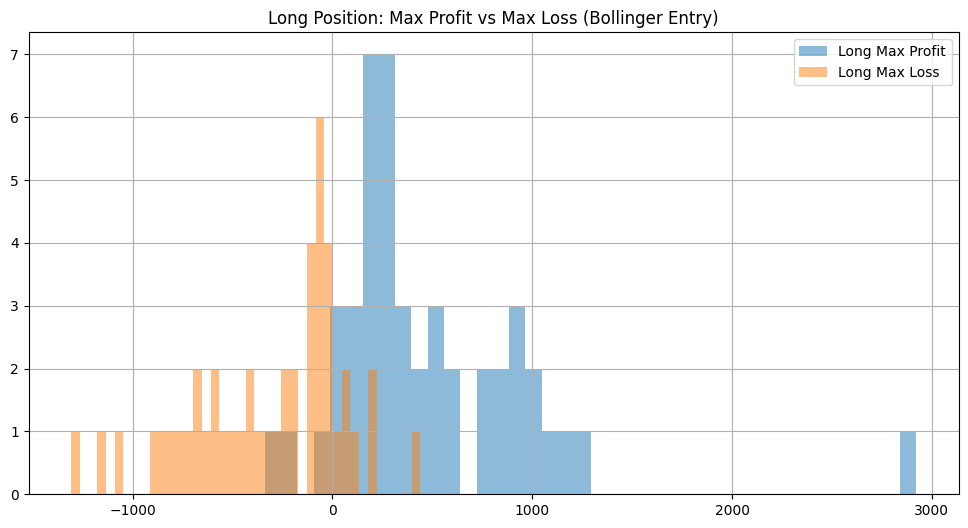

In [3]:
import ccxt
import pandas as pd
import ta
import matplotlib.pyplot as plt
import time

# 🎯 1. CCXT 설정 (Binance 선물)
exchange = ccxt.binance({
    'enableRateLimit': True,
    'options': {
        'defaultType': 'future',  # 선물 시장 사용
    }
})

symbol = 'BTC/USDT'
timeframe = '15m'
limit = 1000  # 최대 데이터 수

# 🎯 2. 캔들 데이터 불러오기
def fetch_ohlcv(symbol, timeframe='1h', limit=1000):
    data = exchange.fetch_ohlcv(symbol, timeframe=timeframe, limit=limit)
    df = pd.DataFrame(data, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
    df['datetime'] = pd.to_datetime(df['timestamp'], unit='ms')
    df.set_index('datetime', inplace=True)
    return df

df = fetch_ohlcv(symbol, timeframe, limit)

# 🎯 3. 볼린저밴드 계산
bb = ta.volatility.BollingerBands(close=df['close'], window=20, window_dev=2)
df['bb_upper'] = bb.bollinger_hband()
df['bb_lower'] = bb.bollinger_lband()
df['bb_middle'] = bb.bollinger_mavg()

# 🎯 4. 볼린저 접촉 후 이동분석
lookahead = 24  # 몇 봉 이후까지 관찰
results = []

for i in range(len(df) - lookahead):
    price = df['close'].iloc[i]
    upper = df['bb_upper'].iloc[i]
    lower = df['bb_lower'].iloc[i]
    
    future_prices = df['close'].iloc[i+1:i+lookahead+1]
    delta = future_prices - price

    if price >= upper:
        results.append({
            'type': 'short',
            'entry_price': price,
            'max_profit': -delta.min(),
            'max_loss': -delta.max(),
            'mean_move': -delta.mean()
        })
    elif price <= lower:
        results.append({
            'type': 'long',
            'entry_price': price,
            'max_profit': delta.max(),
            'max_loss': delta.min(),
            'mean_move': delta.mean()
        })

# 🎯 5. 결과 정리
res_df = pd.DataFrame(results)
longs = res_df[res_df['type'] == 'long']
shorts = res_df[res_df['type'] == 'short']

print("\n📊 Long Entry 분석:")
print(longs[['max_profit', 'max_loss', 'mean_move']].describe())

print("\n📉 Short Entry 분석:")
print(shorts[['max_profit', 'max_loss', 'mean_move']].describe())

# 🎯 6. 히스토그램 시각화
plt.figure(figsize=(12,6))
plt.hist(longs['max_profit'], bins=40, alpha=0.5, label='Long Max Profit')
plt.hist(longs['max_loss'], bins=40, alpha=0.5, label='Long Max Loss')
plt.title("Long Position: Max Profit vs Max Loss (Bollinger Entry)")
plt.legend()
plt.grid()
plt.show()

📊 총 트레이드 수: 46
📈 평균 수익률: 0.01 %
🚀 최대 수익: 0.42 %
📉 최대 손실: -4.27 %
✅ 승률: 78.26 %
💰 총 수익률: 0.36 %
⚠️ 최대 드로우다운: -4.27 %
📌 1번 매수한 횟수: 35
📌 2번 매수한 횟수: 10
📌 3번 매수한 횟수: 0
📌 4번 매수한 횟수: 1


C:\Users\vm\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 47217 (\N{HANGUL SYLLABLE RONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\vm\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 49679 (\N{HANGUL SYLLABLE SYOS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\vm\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 52397 (\N{HANGUL SYLLABLE CEONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\vm\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 49328 (\N{HANGUL SYLLABLE SAN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\vm\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\co

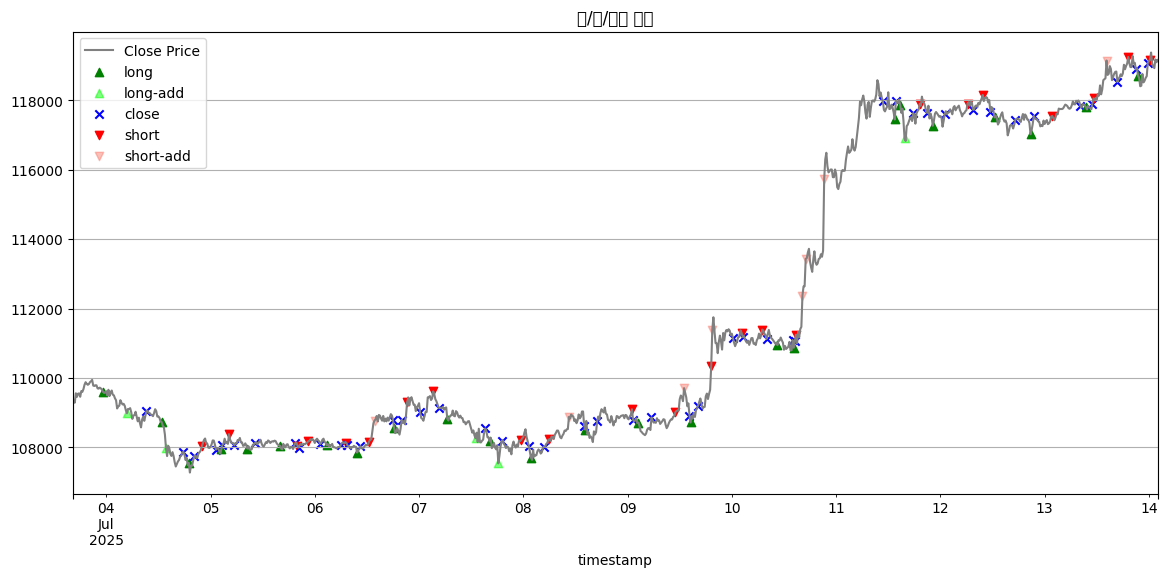

C:\Users\vm\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 51204 (\N{HANGUL SYLLABLE JEON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\vm\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 47029 (\N{HANGUL SYLLABLE RYAG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\vm\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\vm\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 51061 (\N{HANGUL SYLLABLE IG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\vm\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\p

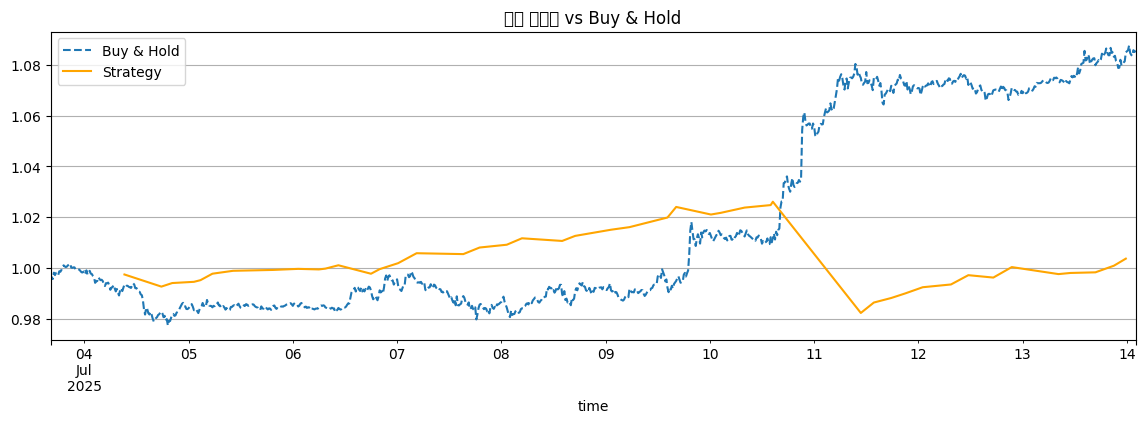

In [6]:
import ccxt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 설정
FEE = 0.0002
THRESHOLD = 0.005  # 0.5%
MAX_ENTRIES = 4
ENTRY_RATIO = [1, 1, 1, 1]
TIMEFRAME = '15m'
symbol = 'BTC/USDT'

# 데이터 로드
exchange = ccxt.binance()
ohlcv = exchange.fetch_ohlcv(symbol, timeframe=TIMEFRAME, limit=1000)
df = pd.DataFrame(ohlcv, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
df.set_index('timestamp', inplace=True)

# 볼린저밴드 계산
df['mbb'] = df['close'].rolling(20).mean()
df['std'] = df['close'].rolling(20).std()
df['upper'] = df['mbb'] + 2 * df['std']
df['lower'] = df['mbb'] - 2 * df['std']

# 상태 변수
trades = []
equity_curve = []
long_short_close = []
entry_count_stat = {1: 0, 2: 0, 3: 0, 4: 0}

current_position = None
entry_prices = []
entry_times = []

# 전략 실행
for i in range(20, len(df)):
    row = df.iloc[i]
    close = row['close']
    high = row['high']
    low = row['low']
    upper = row['upper']
    lower = row['lower']
    mbb = row['mbb']
    now = df.index[i]

    if current_position is None:
        if low <= lower:
            current_position = 'long'
            entry_prices = [close]
            entry_times = [now]
            long_short_close.append((now, close, 'long'))
        elif high >= upper:
            current_position = 'short'
            entry_prices = [close]
            entry_times = [now]
            long_short_close.append((now, close, 'short'))

    elif current_position == 'long':
        last_entry = entry_prices[-1]
        if len(entry_prices) < MAX_ENTRIES and close < last_entry * (1 - THRESHOLD):
            entry_prices.append(close)
            entry_times.append(now)
            long_short_close.append((now, close, 'long-add'))

        elif close >= mbb:
            avg_entry = np.average(entry_prices, weights=ENTRY_RATIO[:len(entry_prices)])
            ret = (close * (1 - FEE) - avg_entry * (1 + FEE)) / avg_entry
            trades.append(ret)
            equity_curve.append({'time': now, 'equity': np.prod([1 + t for t in trades])})
            long_short_close.append((now, close, 'close'))
            entry_count_stat[len(entry_prices)] += 1
            current_position = None
            entry_prices = []
            entry_times = []

    elif current_position == 'short':
        last_entry = entry_prices[-1]
        if len(entry_prices) < MAX_ENTRIES and close > last_entry * (1 + THRESHOLD):
            entry_prices.append(close)
            entry_times.append(now)
            long_short_close.append((now, close, 'short-add'))

        elif close <= mbb:
            avg_entry = np.average(entry_prices, weights=ENTRY_RATIO[:len(entry_prices)])
            ret = (avg_entry * (1 - FEE) - close * (1 + FEE)) / avg_entry
            trades.append(ret)
            equity_curve.append({'time': now, 'equity': np.prod([1 + t for t in trades])})
            long_short_close.append((now, close, 'close'))
            entry_count_stat[len(entry_prices)] += 1
            current_position = None
            entry_prices = []
            entry_times = []

# 📊 성과 지표 계산
total_trades = len(trades)
avg_return = np.mean(trades) if trades else 0
max_profit = np.max(trades) if trades else 0
max_loss = np.min(trades) if trades else 0
win_rate = sum(1 for t in trades if t > 0) / total_trades if trades else 0
total_return = np.prod([1 + t for t in trades]) - 1 if trades else 0

equity_df = pd.DataFrame(equity_curve).set_index('time')
drawdown = equity_df['equity'] / equity_df['equity'].cummax() - 1
max_drawdown = drawdown.min() if not drawdown.empty else 0

# 📈 결과 출력
print("📊 총 트레이드 수:", total_trades)
print("📈 평균 수익률:", round(avg_return * 100, 2), "%")
print("🚀 최대 수익:", round(max_profit * 100, 2), "%")
print("📉 최대 손실:", round(max_loss * 100, 2), "%")
print("✅ 승률:", round(win_rate * 100, 2), "%")
print("💰 총 수익률:", round(total_return * 100, 2), "%")
print("⚠️ 최대 드로우다운:", round(max_drawdown * 100, 2), "%")
print("📌 1번 매수한 횟수:", entry_count_stat[1])
print("📌 2번 매수한 횟수:", entry_count_stat[2])
print("📌 3번 매수한 횟수:", entry_count_stat[3])
print("📌 4번 매수한 횟수:", entry_count_stat[4])

# 📉 시각화 1: 거래 지점
fig, ax = plt.subplots(figsize=(14, 6))
df['close'].plot(ax=ax, label='Close Price', color='gray')

seen = set()
for t, p, signal in long_short_close:
    label = signal if signal not in seen else None
    seen.add(signal)
    if signal == 'long':
        ax.scatter(t, p, color='green', marker='^', label=label)
    elif signal == 'short':
        ax.scatter(t, p, color='red', marker='v', label=label)
    elif signal == 'close':
        ax.scatter(t, p, color='blue', marker='x', label=label)
    elif signal == 'long-add':
        ax.scatter(t, p, color='lime', marker='^', alpha=0.5, label=label)
    elif signal == 'short-add':
        ax.scatter(t, p, color='salmon', marker='v', alpha=0.5, label=label)

ax.set_title('롱/숏/청산 시점')
ax.legend()
plt.grid(True)
plt.show()

# 📊 시각화 2: 전략 vs Buy & Hold
plt.figure(figsize=(14, 4))
(df['close'] / df['close'].iloc[20]).plot(label='Buy & Hold', linestyle='--')
if not equity_df.empty:
    equity_df['equity'].plot(label='Strategy', color='orange')
plt.title('전략 수익률 vs Buy & Hold')
plt.legend()
plt.grid(True)
plt.show()


📊 총 트레이드 수: 46
📈 평균 수익률: -0.01 %
🚀 최대 수익: 0.42 %
📉 최대 손실: -5.05 %
✅ 승률: 78.26 %
💰 총 수익률: -0.46 %
⚠️ 최대 드로우다운: -5.05 %
📌 1번 매수한 횟수: 35
📌 2번 매수한 횟수: 10
📌 3번 매수한 횟수: 1
📌 4번 매수한 횟수: 0


C:\Users\vm\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 47217 (\N{HANGUL SYLLABLE RONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\vm\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 49679 (\N{HANGUL SYLLABLE SYOS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\vm\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 52397 (\N{HANGUL SYLLABLE CEONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\vm\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 49328 (\N{HANGUL SYLLABLE SAN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\vm\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\co

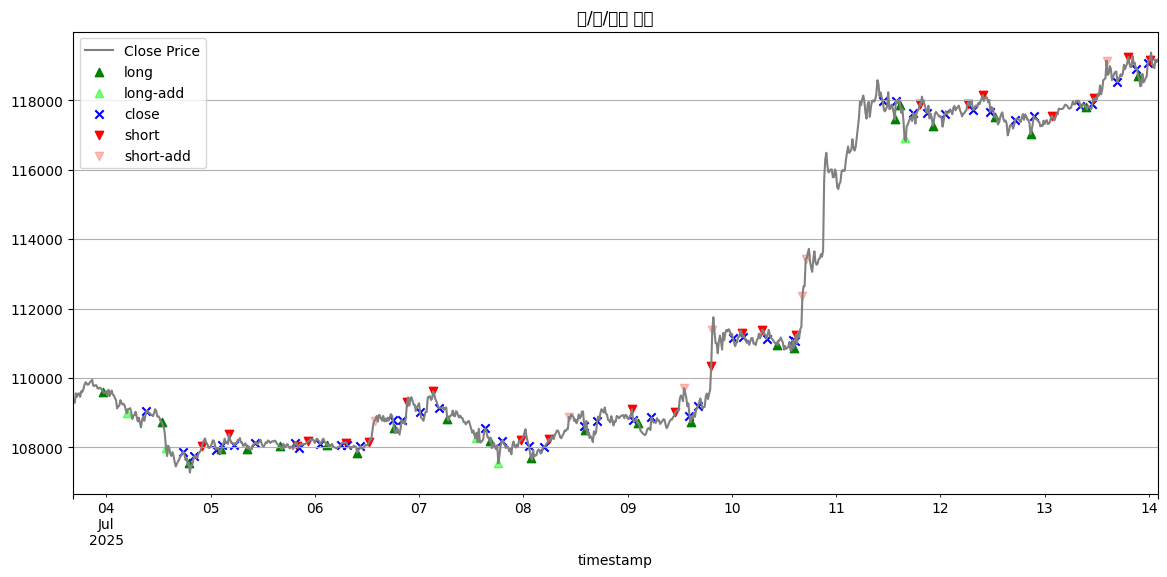

C:\Users\vm\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 51204 (\N{HANGUL SYLLABLE JEON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\vm\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 47029 (\N{HANGUL SYLLABLE RYAG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\vm\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\vm\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 51061 (\N{HANGUL SYLLABLE IG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\vm\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\p

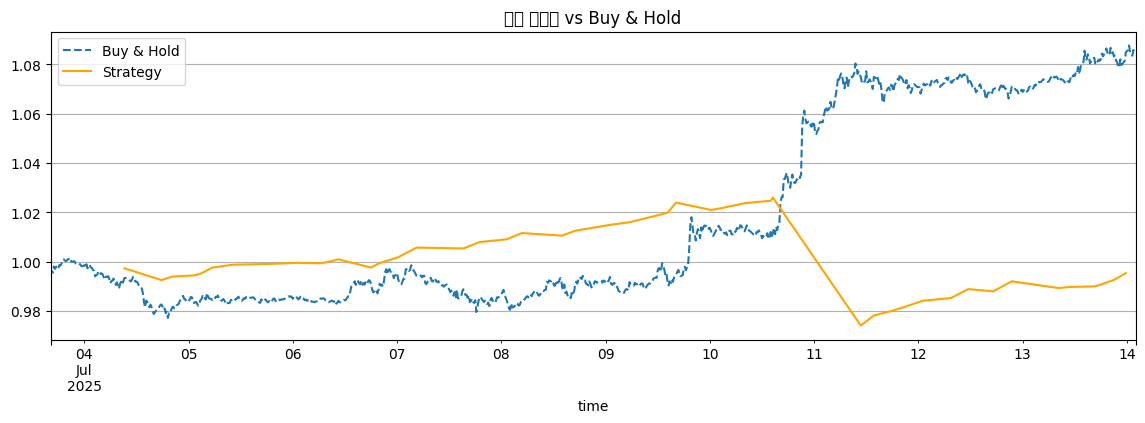

In [7]:
import ccxt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 설정
FEE = 0.0002
THRESHOLD = 0.005  # 0.5%
MAX_ENTRIES = 3
ENTRY_RATIO = [1, 1, 1]
TIMEFRAME = '15m'
symbol = 'BTC/USDT'

# 데이터 로드
exchange = ccxt.binance()
ohlcv = exchange.fetch_ohlcv(symbol, timeframe=TIMEFRAME, limit=1000)
df = pd.DataFrame(ohlcv, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
df.set_index('timestamp', inplace=True)

# 볼린저밴드 계산
df['mbb'] = df['close'].rolling(20).mean()
df['std'] = df['close'].rolling(20).std()
df['upper'] = df['mbb'] + 2 * df['std']
df['lower'] = df['mbb'] - 2 * df['std']

# 상태 변수
trades = []
equity_curve = []
long_short_close = []
entry_count_stat = {1: 0, 2: 0, 3: 0, 4: 0}

current_position = None
entry_prices = []
entry_times = []

# 전략 실행
for i in range(20, len(df)):
    row = df.iloc[i]
    close = row['close']
    high = row['high']
    low = row['low']
    upper = row['upper']
    lower = row['lower']
    mbb = row['mbb']
    now = df.index[i]

    if current_position is None:
        if low <= lower:
            current_position = 'long'
            entry_prices = [close]
            entry_times = [now]
            long_short_close.append((now, close, 'long'))
        elif high >= upper:
            current_position = 'short'
            entry_prices = [close]
            entry_times = [now]
            long_short_close.append((now, close, 'short'))

    elif current_position == 'long':
        last_entry = entry_prices[-1]
        if len(entry_prices) < MAX_ENTRIES and close < last_entry * (1 - THRESHOLD):
            entry_prices.append(close)
            entry_times.append(now)
            long_short_close.append((now, close, 'long-add'))

        elif close >= mbb:
            avg_entry = np.average(entry_prices, weights=ENTRY_RATIO[:len(entry_prices)])
            ret = (close * (1 - FEE) - avg_entry * (1 + FEE)) / avg_entry
            trades.append(ret)
            equity_curve.append({'time': now, 'equity': np.prod([1 + t for t in trades])})
            long_short_close.append((now, close, 'close'))
            entry_count_stat[len(entry_prices)] += 1
            current_position = None
            entry_prices = []
            entry_times = []

    elif current_position == 'short':
        last_entry = entry_prices[-1]
        if len(entry_prices) < MAX_ENTRIES and close > last_entry * (1 + THRESHOLD):
            entry_prices.append(close)
            entry_times.append(now)
            long_short_close.append((now, close, 'short-add'))

        elif close <= mbb:
            avg_entry = np.average(entry_prices, weights=ENTRY_RATIO[:len(entry_prices)])
            ret = (avg_entry * (1 - FEE) - close * (1 + FEE)) / avg_entry
            trades.append(ret)
            equity_curve.append({'time': now, 'equity': np.prod([1 + t for t in trades])})
            long_short_close.append((now, close, 'close'))
            entry_count_stat[len(entry_prices)] += 1
            current_position = None
            entry_prices = []
            entry_times = []

# 📊 성과 지표 계산
total_trades = len(trades)
avg_return = np.mean(trades) if trades else 0
max_profit = np.max(trades) if trades else 0
max_loss = np.min(trades) if trades else 0
win_rate = sum(1 for t in trades if t > 0) / total_trades if trades else 0
total_return = np.prod([1 + t for t in trades]) - 1 if trades else 0

equity_df = pd.DataFrame(equity_curve).set_index('time')
drawdown = equity_df['equity'] / equity_df['equity'].cummax() - 1
max_drawdown = drawdown.min() if not drawdown.empty else 0

# 📈 결과 출력
print("📊 총 트레이드 수:", total_trades)
print("📈 평균 수익률:", round(avg_return * 100, 2), "%")
print("🚀 최대 수익:", round(max_profit * 100, 2), "%")
print("📉 최대 손실:", round(max_loss * 100, 2), "%")
print("✅ 승률:", round(win_rate * 100, 2), "%")
print("💰 총 수익률:", round(total_return * 100, 2), "%")
print("⚠️ 최대 드로우다운:", round(max_drawdown * 100, 2), "%")
print("📌 1번 매수한 횟수:", entry_count_stat[1])
print("📌 2번 매수한 횟수:", entry_count_stat[2])
print("📌 3번 매수한 횟수:", entry_count_stat[3])
print("📌 4번 매수한 횟수:", entry_count_stat[4])

# 📉 시각화 1: 거래 지점
fig, ax = plt.subplots(figsize=(14, 6))
df['close'].plot(ax=ax, label='Close Price', color='gray')

seen = set()
for t, p, signal in long_short_close:
    label = signal if signal not in seen else None
    seen.add(signal)
    if signal == 'long':
        ax.scatter(t, p, color='green', marker='^', label=label)
    elif signal == 'short':
        ax.scatter(t, p, color='red', marker='v', label=label)
    elif signal == 'close':
        ax.scatter(t, p, color='blue', marker='x', label=label)
    elif signal == 'long-add':
        ax.scatter(t, p, color='lime', marker='^', alpha=0.5, label=label)
    elif signal == 'short-add':
        ax.scatter(t, p, color='salmon', marker='v', alpha=0.5, label=label)

ax.set_title('롱/숏/청산 시점')
ax.legend()
plt.grid(True)
plt.show()

# 📊 시각화 2: 전략 vs Buy & Hold
plt.figure(figsize=(14, 4))
(df['close'] / df['close'].iloc[20]).plot(label='Buy & Hold', linestyle='--')
if not equity_df.empty:
    equity_df['equity'].plot(label='Strategy', color='orange')
plt.title('전략 수익률 vs Buy & Hold')
plt.legend()
plt.grid(True)
plt.show()
